<a href="https://colab.research.google.com/github/davidcpage/Imagenette-experiments/blob/master/Architecture_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we perform some manual architecture search in the spirit of https://myrtle.ai/how-to-train-your-resnet-4-architecture/.

### Setup

Install fastai2 and DALI. You may need to restart afterwards.

In [0]:
!nvidia-smi

In [0]:
!python -m pip install typeguard
!python -m pip install --upgrade pillow fastprogress
!python -m pip install git+https://github.com/fastai/fastai2
!python -m pip install --extra-index-url https://developer.download.nvidia.com/compute/redist/cuda/10.0 nvidia-dali

UTILS = 'https://raw.githubusercontent.com/davidcpage/Imagenette-experiments/master/utils.py'
RANGER = 'https://raw.githubusercontent.com/lessw2020/Ranger-Mish-ImageWoof-5/master/ranger.py'

!wget $RANGER -O ranger.py
!wget $UTILS -O utils.py

CORE = 'https://raw.githubusercontent.com/davidcpage/cifar10-fast/master/core.py'
!wget $CORE -O core.py

### Main

Imports, device setup and dataset download:

In [0]:
from functools import partial
import numpy as np
import torch
import torch.nn as nn
import fastai, fastai.vision
import fastai2, fastai2.callback.all

import ranger
from utils import *

data_dir = fastai.datasets.untar_data(fastai.datasets.URLs.IMAGENETTE_160)
device = torch.device(torch.cuda.current_device())

torch.backends.cudnn.benchmark = True

Here is a function to build the proposed new 70:30 train/val dataset split:

In [0]:
from pathlib import Path
import shutil
import os

def make_new_data_split(data_dir, new_data_dir):
    shutil.copytree(data_dir, new_data_dir)
    train_dir, val_dir = Path(new_data_dir)/'train', Path(new_data_dir)/'val'
    #empty val_dir
    for k in os.listdir(val_dir):
        for f in os.listdir(val_dir/k):
            shutil.move(str(val_dir/k/f), train_dir/k)
    #move examples ending in 0,1 or 2 to val_dir
    for k in os.listdir(train_dir):
        to_move=[f for f in os.listdir(train_dir/k) if f[-6] in {'0','1','2'}]
        for f in to_move:
            shutil.move(str(train_dir/k/f), val_dir/k)

new_data_dir = Path(str(data_dir)+'-new')

In [0]:
make_new_data_split(data_dir, new_data_dir)

### DALI DataLoaders

In [0]:
size = 128
bs = 64
random_aspect_ratio = (3/4, 4/3)
random_area = (0.35, 1.)
val_xtra_size = 32

to = lambda dtype: (lambda b: (b[0].to(dtype), b[1]))

train_dl = lambda folder, bs, dtype=torch.float16: (
        Map(to(dtype), DALIDataLoader(imagenet_train_graph(folder, size, random_aspect_ratio, random_area), bs, drop_last=True, device=device)))
valid_dl = lambda folder, bs, dtype=torch.float16: Chain(
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size), bs, drop_last=False, device=device)),
        Map(to(dtype), DALIDataLoader(imagenet_valid_graph(folder, size, val_xtra_size, mirror=1), bs, drop_last=False, device=device)),
    )

data = lambda data_dir=new_data_dir, bs=bs, dtype=torch.float16: fastai2.basics.DataBunch(train_dl(data_dir/'train', bs, dtype), valid_dl(data_dir/'val', bs, dtype))

### Basic ops

In [0]:
from core import DotGraph, ColorMap, build_graph, remove_by_type

class Mul(nn.Module):
    def forward(self, x, y): return x * y

class Add(nn.Module):
    def forward(self, x, y): return x + y

class Noop(): 
    def __init__(self, *args, **kwargs): pass

class BatchNorm(nn.BatchNorm2d):
    def __init__(self, *args, zero=False, **kwargs):
        super().__init__(*args, **kwargs)
        if self.affine:
            self.weight.data.fill_(0. if zero else 1.)

class Network(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.graph = remove_by_type(union({'input': (None, [])}, net), Noop)
        for path, (val, _) in self.graph.items(): 
            setattr(self, path.replace('/', '_'), val)
    
    def forward(self, x):
        outputs = {'input': x}
        for k, (node, ins) in self.graph.items():
            if k not in outputs: 
                outputs[k] = node(*[outputs[x] for x in ins])
        return outputs['classifier']

colors = ColorMap()
def draw(network, **kwargs):
    if not isinstance(network, Network):
        network = Network(network)
    display(DotGraph({p: ({'fillcolor': colors[type(v).__name__], 'tooltip': repr(v)}, inputs) for p, (v, inputs) in network.graph.items() if v is not None}, **kwargs))

### Layers

In [0]:
def conv_layer(ni, nf, ks=3, stride=1, padding=None, groups=1, bias=None, norm=BatchNorm, act_cls=MishJit, conv=nn.Conv2d):
    return {
        'conv': nn.Conv2d(ni, nf, ks, stride=stride, padding=((ks-1)//2 if padding is None else padding), groups=groups, bias=bias),
        'norm': norm(nf), 
        'act': act_cls()
    }

draw(conv_layer(32,64), size=3)

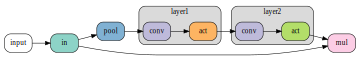

In [0]:
def se_module(ch, reduction):
    print
    return {
        'in': nn.Identity(),
        'pool': nn.AdaptiveAvgPool2d(1),
        'layer1': conv_layer(ch, ch//reduction, ks=1, norm=Noop, bias=True, act_cls=nn.ReLU),
        'layer2': conv_layer(ch//reduction, ch, ks=1, norm=Noop, bias=True, act_cls=nn.Sigmoid),
        'mul': (Mul(), [-1, 'in']),
    }

draw(se_module(64, 16), size=5)

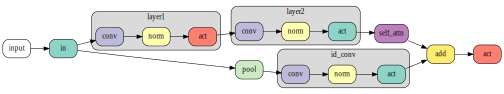

In [0]:
#res_block with expansion=1
def res_block_a(ni, nf, stride=1, groups=1, groups2=1, sa=False, reduction=None, nh=None, norm=BatchNorm, act_cls=MishJit):
    if nh is None: nh = nf
    return {
        'in': nn.Identity(),
        'layer1': conv_layer(ni, nh, 3, stride=stride, groups=groups, norm=norm, act_cls=act_cls),
        'layer2': conv_layer(nh, nf, 3, groups=groups2, norm=partial(norm, zero=True), act_cls=nn.Identity),
        'squeeze_excite': (se_module(nf, reduction=reduction) if reduction else Noop()),
        'self_attn': (fastai2.layers.SimpleSelfAttention(nf, ks=1, sym=0) if sa else Noop()),
        'pool': (Noop() if stride==1 else nn.AvgPool2d(2, ceil_mode=True), ['in']),
        'id_conv': (Noop() if ni==nf else conv_layer(ni, nf, ks=1, act_cls=nn.Identity)),
        'add': (Add(), [-1, 'self_attn']),
        'act': act_cls(),
    }

draw(res_block_a(32, 64, stride=2, sa=True), size=7)

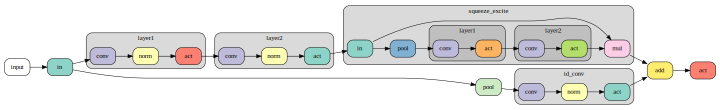

In [0]:
def separable_block(ni, nf, reduction=16, stride=1, **kwargs):
    return res_block_a(ni,  nf, stride=stride, reduction=reduction, nh=nf*2, groups=ni, **kwargs)

draw(separable_block(32, 64, stride=2), size=10)

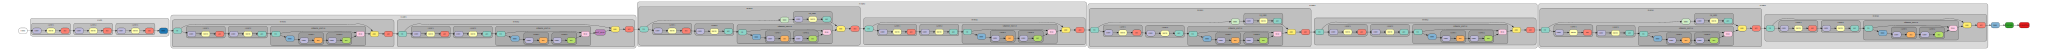

In [0]:
def xresnet_stem(sizes, act_cls):
    return dict({f'layer{i+1}': conv_layer(sizes[i], sizes[i+1],  stride=2 if i==0 else 1, act_cls=act_cls) for i in range(len(sizes)-1)},
                pool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

def xresnet_block_spec(layers,  sizes):
    return [[{'ni': sizes[i],   'nf': sizes[i+1], 'stride': 1 if i==0 else 2}] + 
            [{'ni': sizes[i+1], 'nf': sizes[i+1], 'stride': 1}] * (l-1) 
            for i,l in enumerate(layers)]

def make_blocks(block, spec):
    return {f'stage{i}': {f'block{j}': block(**kw) for j,kw in enumerate(stage,1)} for i,stage in enumerate(spec,1)}

def xresnet_head(n_features, c_out, p):
    return {
        'pool': nn.AdaptiveAvgPool2d(1), 
        'flatten': fastai2.layers.Flatten(),
        'dropout': (Noop() if p is None else nn.Dropout(p)),
        'classifier': nn.Linear(n_features, c_out)
    }

def xresnet(block, layers, c_in, c_out, sa=False, p=None, act_cls=MishJit, stem_sizes=None, layer_sizes=None, stem_func=xresnet_stem):
    if not stem_sizes: 
        stem_sizes = [16,32,64] if c_in < 3 else [32,64,64]
    if not layer_sizes:
        layer_sizes = [64,128,256,512] + [256]*(len(layers)-4)
    block_spec = xresnet_block_spec(layers, [stem_sizes[-1]] + layer_sizes)
    if sa: block_spec[-4][-1]['sa'] = True
    return union(
        {'stem': stem_func([c_in] + stem_sizes, act_cls)}, 
        make_blocks(partial(block, act_cls=act_cls), block_spec),
        xresnet_head(layer_sizes[-1], c_out, p)
    )

draw(xresnet(separable_block, [2,2,2,2], c_in=3, c_out=10, sa=True), size=50)

In [0]:
colors

{'AdaptiveAvgPool2d': '#80b1d3',
 'Add': '#ffed6f',
 'AvgPool2d': '#ccebc5',
 'BatchNorm': '#ffffb3',
 'Conv2d': '#bebada',
 'Flatten': '#33a02c',
 'Identity': '#8dd3c7',
 'Linear': '#e31a1c',
 'MaxPool2d': '#1f78b4',
 'MishJit': '#fb8072',
 'Mul': '#fccde5',
 'ReLU': '#fdb462',
 'Sigmoid': '#b3de69',
 'SimpleSelfAttention': '#bc80bd'}

In [0]:
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d, nn.Linear)): 
        nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
    return m

def XResNet(block, layers=(2,2,2,2), p=None, c_in=3, c_out=10, sa=False, act_cls=MishJit, **kwargs):
    return init_cnn(Network(xresnet(block, layers, p=p, c_in=c_in, c_out=c_out, sa=sa, act_cls=act_cls, **kwargs)))

### Training

In [0]:
def smoothed_acc(logits, targets, beta=3.): #replace argmax with soft(arg)max
    return torch.mean(nn.functional.softmax(logits*beta, dim=-1)[torch.arange(0, targets.size(0), device=device), targets])

RangerWrapper = lambda *args, **kwargs: fastai2.basics.OptimWrapper(ranger.Ranger(*args, **kwargs))

def add_opt(learn):
    skip_wd = split_params((lambda mod, name: isinstance(mod, nn.BatchNorm2d) or name=='bias'), learn.model)
    learn.opt = learn.opt_func([{'params': skip_wd[False]}, {'params': skip_wd[True]}], lr=0.1)
    return learn

learner_v2 = lambda data, model: add_opt(
    fastai2.basics.Learner(
        data, model, lr=0.0,
        opt_func=partial(RangerWrapper, betas=(0.95, 0.99), eps=1e-6),
        metrics=[fastai2.metrics.accuracy, smoothed_acc],
        loss_func=fastai2.basics.LabelSmoothingCrossEntropy())
    )



**Baseline model**

Compared to the [Imagenette leaderboard](https://github.com/fastai/imagenette) result of 89.5% we are using a smaller xresnet18 model (-1%) lower-res data pre-augmentation (-1.5%) and a harder dataset (-6%). Note the slightly higher learning rate we are using for the smaller dataset.

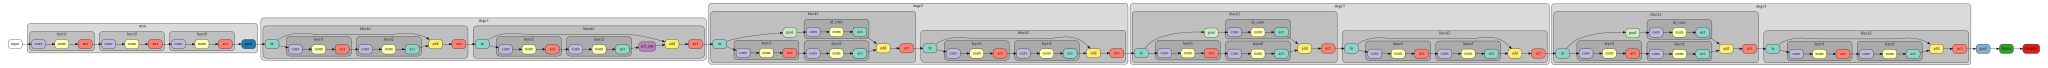

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.546324,1.420166,0.619618,0.585042,00:13
1,1.319691,1.170587,0.726624,0.706599,00:12
2,1.185535,1.342356,0.660892,0.642814,00:12
3,1.101501,1.040393,0.791975,0.772248,00:12
4,0.986793,0.987880,0.812102,0.794400,00:12


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(res_block_a, [2,2,2,2], c_in=3, c_out=10, sa=True))
draw(learn.model, size=40)
learn.fit_flat_cos(5, lr=6e-3, wd=[1e-2, 0.0], pct_start=0.72)

**Separable block model**

Model with separable block (proposed by JPH) consisting of a 3x3 depthwise conv followed by an ordinary 3x3 conv.

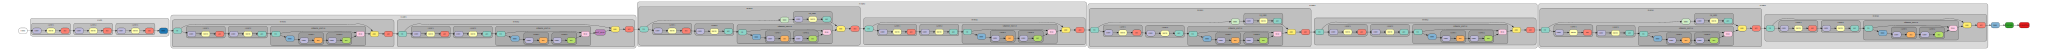

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.556337,1.482624,0.608280,0.589578,00:15
1,1.244726,1.145133,0.742293,0.723266,00:14
2,1.098540,1.181365,0.733631,0.716012,00:14
3,1.001653,0.976112,0.812994,0.798423,00:14
4,0.875051,0.894291,0.845350,0.833757,00:14


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(separable_block, [2,2,2,2], c_in=3, c_out=10, sa=True))
draw(learn.model, size=50)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

**Remove branches**

Let's remove all the branches and test the backbone network. We also remove extra activation functions along the spine.

In [0]:
def simple_block(ni, nf, stride=1, norm=BatchNorm, act_cls=MishJit, pool=nn.AvgPool2d, ks=1):
    return {
        'pool': (Noop() if stride==1 else pool(2, ceil_mode=True)),
        'id_conv': (Noop() if ni==nf else conv_layer(ni, nf, ks=ks, act_cls=act_cls)),
    }

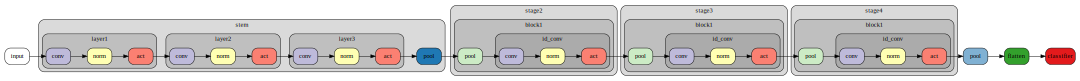

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.634254,1.615214,0.542675,0.513009,00:06
1,1.440968,1.375317,0.643312,0.617026,00:06
2,1.369891,1.467186,0.606624,0.587896,00:06
3,1.292456,1.268607,0.677070,0.656239,00:06
4,1.158747,1.124010,0.752994,0.729474,00:06


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(simple_block, c_in=3, c_out=10))
draw(learn.model, size=15)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

**Kernel size=3 for backbone convs** 

The convolutions in the main part of the network above are 1x1 - let's replace them with 3x3 convs.

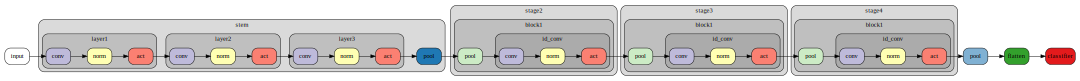

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.595300,1.615185,0.540764,0.523649,00:07
1,1.428139,1.309278,0.662293,0.644565,00:06
2,1.282427,1.347042,0.668535,0.649606,00:07
3,1.223457,1.165559,0.728408,0.710608,00:06
4,1.083428,1.054573,0.775032,0.758306,00:07


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(partial(simple_block, ks=3), c_in=3, c_out=10))
draw(learn.model, size=15)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

**AvgPool -> MaxPool**

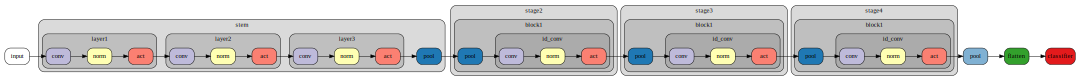

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.487578,1.599534,0.546369,0.534086,00:06
1,1.325277,1.217114,0.709809,0.690260,00:06
2,1.197838,1.284033,0.677580,0.664141,00:06
3,1.144358,1.116514,0.752994,0.732813,00:06
4,1.002501,0.991307,0.808280,0.791781,00:06


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(partial(simple_block, ks=3, pool=nn.MaxPool2d), c_in=3, c_out=10))
draw(learn.model, size=15)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

Note, we are already competitive with the leaderboard model..!

**Separable blocks along spine**

Let's try putting the separable blocks - that worked so well in branches - along the spine:

In [0]:
def sep_conv(ni, nf, stride=1, norm=BatchNorm, act_cls=MishJit, pool=nn.AvgPool2d, ks=1):
    return {
        'pool': (Noop() if stride==1 else pool(2, ceil_mode=True)),
        'conv1': (Noop() if ni==nf else conv_layer(ni, nf*2, ks=ks, act_cls=act_cls, groups=ni)),
        'conv2': (Noop() if ni==nf else conv_layer(nf*2, nf, ks=ks, act_cls=act_cls)),
    }

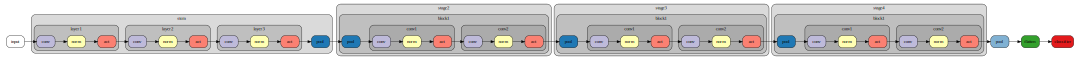

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.397648,1.312438,0.676561,0.654834,00:08
1,1.199681,1.093657,0.763439,0.749664,00:08
2,1.094338,1.154105,0.741147,0.725493,00:08
3,1.011688,0.994460,0.811592,0.797294,00:08
4,0.895973,0.909771,0.844586,0.831572,00:08


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(partial(sep_conv, ks=3, pool=nn.MaxPool2d), c_in=3, c_out=10))
draw(learn.model, size=15)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

**Moving pooling layers**

Moving pooling layers to the end of blocks costs some extra computation but may be worthwhile:

In [0]:
reorder = lambda net, keys: {k: net[k] for k in keys}
sep_conv_2 = lambda *args, **kwargs: reorder(sep_conv(*args, **kwargs), ['conv1', 'conv2', 'pool']) 

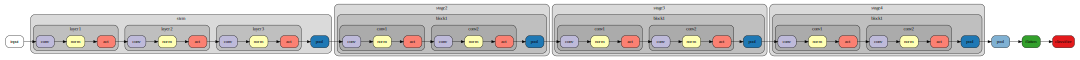

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.430991,1.293460,0.683185,0.662513,00:12
1,1.223518,1.085311,0.775541,0.760651,00:11
2,1.123007,1.112554,0.778981,0.763572,00:11
3,1.036428,0.975725,0.829554,0.812330,00:11
4,0.903177,0.911544,0.857070,0.840014,00:11


In [0]:
learn = learner_v2(data(dtype=torch.float), XResNet(partial(sep_conv_2, ks=3, pool=nn.MaxPool2d), c_in=3, c_out=10))
draw(learn.model, size=15)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

This appears to have overtaken the full separable block model! Let's test things out on the original dataset to see how we compare to the leaderboard accuracy of 89.5%. First let's download a higher-res version to use pre-augmentation (network inputs are still 128x128) since this makes a difference:

In [0]:
data_dir_320 = fastai.datasets.untar_data(fastai.datasets.URLs.IMAGENETTE_320)

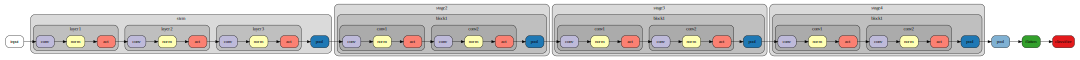

epoch,train_loss,valid_loss,accuracy,smoothed_acc,time
0,1.313604,1.471255,0.640000,0.620282,00:13
1,1.129791,0.957958,0.849000,0.828912,00:13
2,1.035385,0.979283,0.825000,0.811328,00:13
3,0.959583,0.857170,0.886000,0.872100,00:13
4,0.832634,0.785744,0.912000,0.904419,00:13


In [0]:
learn = learner_v2(data(data_dir=data_dir_320, dtype=torch.float), XResNet(partial(sep_conv_2, ks=3, pool=nn.MaxPool2d), c_in=3, c_out=10))
draw(learn.model, size=15)
learn.fit_flat_cos(5, lr=8e-3, wd=[1e-2, 0.0], pct_start=0.72)

To be continued...